In [1]:
!pip install transformers torch pandas scikit-learn datasets openpyxl pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.5 MB/s eta 0:00:00


## Lib

In [2]:
import torch
from transformers.utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, AutoConfig
from transformers import DataCollatorWithPadding 
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns 
# from imblearn.over_sampling import SMOTE # Loại bỏ nếu không sử dụng SMOTE
os.environ["WANDB_DISABLED"] = "true"
import warnings

warnings.filterwarnings("ignore")

SEED = 25
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Load data

In [3]:
df = pd.read_csv('/kaggle/input/dataset-location/combined_location_data.csv',encoding='utf-8')

In [4]:
df.sample(5)

,address,label
3085441,Tổ 9 Chạy_nhanh,0
94780,"ấp Bà Điều xã Lý_Văn_Lâm K5 , F1 , Thành_phố...",1
3246694,Tôi chỉ đành tạm_thời gác lại ý_định đi khám_phá,0
3282522,Đường Ngôi_nhà 200,0
982446,Quận 473 Mạnh_mẽ Hấp_dẫn,0


In [5]:
df['label'] = df['label'].astype(int)

print("Các nhãn duy nhất trong dữ liệu:")
print(df['label'].unique())
assert set(df['label'].unique()) == {0, 1}, "Cột 'label' phải chỉ chứa giá trị 0 và 1."

Các nhãn duy nhất trong dữ liệu:
[0 1]


In [6]:
# Tách dữ liệu thành tập huấn luyện (train), xác thực (validation) và kiểm tra (test)
# Tỷ lệ: 80% train, 10% validation, 10% test
train_texts_labels, test_texts_labels = train_test_split(
    df[['address', 'label']],
    test_size=0.2, # Giữ lại 20% cho validation và test
    random_state=SEED,
    stratify=df['label'] # Giữ tỷ lệ nhãn trong các tập con
)

valid_texts_labels, test_texts_labels = train_test_split(
    test_texts_labels,
    test_size=0.5, # Chia 20% còn lại thành 10% validation và 10% test
    random_state=SEED,
    stratify=test_texts_labels['label'] # Giữ tỷ lệ nhãn
)

In [7]:
train_texts = list(train_texts_labels['address'])
train_labels = list(train_texts_labels['label'])

valid_texts = list(valid_texts_labels['address'])
valid_labels = list(valid_texts_labels['label'])

test_texts = list(test_texts_labels['address'])
test_labels = list(test_texts_labels['label'])

print(f"Kích thước tập huấn luyện: {len(train_texts)}")
print(f"Kích thước tập xác thực: {len(valid_texts)}")
print(f"Kích thước tập kiểm tra: {len(test_texts)}")

target_names = ['Not Address', 'Address'] # Nhãn tương ứng với 0 và 1

Kích thước tập huấn luyện: 2797738
Kích thước tập xác thực: 349717
Kích thước tập kiểm tra: 349718


# 2. Tokenization

In [8]:
model_name = "vinai/phobert-base" 
max_length = 32 

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

# Tokenize dữ liệu
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

# 3. Create Dataset Pytorch

In [10]:
class AddressDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = AddressDataset(train_encodings, train_labels)
valid_dataset = AddressDataset(valid_encodings, valid_labels)
test_dataset = AddressDataset(test_encodings, test_labels)

# 4. Model

In [12]:
label2id = {"Not Address": 0, "Address": 1}
id2label = {0: "Not Address", 1: "Address"}

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    label2id=label2id,
    id2label=id2label
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Metrics

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted') # 'weighted' tính F1 cho mỗi nhãn và tìm trung bình có trọng số
                                                    # 'binary' chỉ tính cho lớp positive (1)
                                                    # 'macro' tính F1 cho mỗi nhãn và tìm trung bình không trọng số
    return {
        'accuracy': acc,
        'f1': f1,
    }

# 6. Training Arguments 

In [15]:
training_args = TrainingArguments(
    output_dir='./address_classifier_model', # Thư mục lưu model
    evaluation_strategy="epoch",      # Đánh giá sau mỗi epoch
    save_strategy='epoch',            # Lưu model sau mỗi epoch
    metric_for_best_model="f1",       # Chọn model tốt nhất dựa trên F1 score (hoặc 'accuracy')
    load_best_model_at_end=True,      # Tải model tốt nhất khi kết thúc huấn luyện
    greater_is_better=True,           # F1/Accuracy càng cao càng tốt
    num_train_epochs=1,               # Giảm số epoch để chạy nhanh hơn (có thể tăng lên 5 hoặc hơn)
    per_device_train_batch_size=32,   # Batch size cho huấn luyện
    per_device_eval_batch_size=64,    # Batch size cho đánh giá (thường có thể lớn hơn)
    warmup_steps=100,                 # Số bước warmup
    weight_decay=0.01,                # Weight decay
    learning_rate=2e-5,               # Learning rate (thường nhỏ hơn cho fine-tuning)
    # gradient_accumulation_steps=1,  # Bỏ qua nếu không cần
    # lr_scheduler_type="cosine",       # Có thể dùng scheduler khác hoặc mặc định ('linear')
    logging_dir='./logs',             # Thư mục lưu log
    logging_steps=round(len(train_dataset) / (16 * torch.cuda.device_count() if torch.cuda.is_available() else 1) / 10), # Log thường xuyên hơn
    save_total_limit=2                # Giới hạn số lượng checkpoint được lưu
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 7. Data Collator và Trainer

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# 8. Training

In [17]:
print("Bắt đầu huấn luyện...")
time_start = time.time()

trainer.train()

time_end = time.time()
total_time = time_end - time_start
print(f"Thời gian huấn luyện: {total_time:.2f} giây")

Bắt đầu huấn luyện...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.001500,0.001272,0.999834,0.999834


Thời gian huấn luyện: 11072.92 giây


# 9. Evaluate

In [18]:
print("\nĐánh giá trên validation set:")
eval_results = trainer.evaluate()
print(eval_results)

print("\nĐánh giá trên test set:")
pred_output = trainer.predict(test_dataset)

# Lấy dự đoán và nhãn thực tế
y_pred = np.argmax(pred_output.predictions, axis=1)
y_true = test_labels # Sử dụng test_labels đã tách trước đó

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))


Đánh giá trên validation set:


{'eval_loss': 0.0012716165510937572, 'eval_accuracy': 0.9998341516140193, 'eval_f1': 0.9998341507294893, 'eval_runtime': 327.1607, 'eval_samples_per_second': 1068.946, 'eval_steps_per_second': 16.704, 'epoch': 1.0}

Đánh giá trên test set:

Classification Report:
              precision    recall  f1-score   support

 Not Address      1.000     1.000     1.000    185000
     Address      1.000     1.000     1.000    164718

    accuracy                          1.000    349718
   macro avg      1.000     1.000     1.000    349718
weighted avg      1.000     1.000     1.000    349718



# 10. Confused matrix

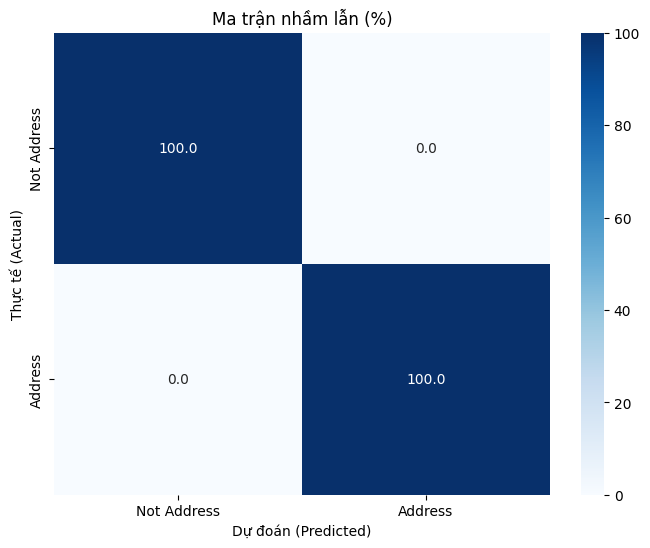


Hoàn thành!


In [19]:
confuse = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))

# Tính toán tỷ lệ phần trăm
confuse_percent = np.round(np.divide(confuse, np.sum(confuse, axis=1, keepdims=True)) * 100, 1)

sns.heatmap(confuse_percent, annot=True, fmt=".1f", cmap='Blues', ax=ax,
            xticklabels=target_names, yticklabels=target_names)

# sns.heatmap(confuse, annot=True, fmt="d", cmap='Blues', ax=ax, # Hiển thị số lượng tuyệt đối
#             xticklabels=target_names, yticklabels=target_names)


ax.set_xlabel('Dự đoán (Predicted)')
ax.set_ylabel('Thực tế (Actual)');
ax.set_title('Ma trận nhầm lẫn (%)')

plt.show()

print("\nHoàn thành!")